In [42]:
# -------------------------- Get Raw data

import pandas as pd
import matplotlib.pyplot as plt

# RIGHT (1)
# Load OpenBCI data
path = "C:/Quick_Disk/tonge_emg_xr_project/data/Recordings3_right/recording3_right.csv"
df1 = pd.read_csv(path, sep='\t', skiprows=5, engine='python')

# Rename columns name for clarity
df1.columns = [f"ch_{i}" for i in range(df1.shape[1])]
print(" RIGHT")
print(df1.columns.tolist())

# LEFT (2)
# Load OpenBCI data
path = "C:/Quick_Disk/tonge_emg_xr_project/data/Recordings3_left/recording3_left.csv"
df2 = pd.read_csv(path, sep='\t', skiprows=5, engine='python')

# Rename columns name for clarity
df2.columns = [f"ch_{i}" for i in range(df2.shape[1])]
print(" LEFT")
print(df2.columns.tolist())



 RIGHT
['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23']
 LEFT
['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23']


In [43]:
# -------------------------- Filtering

from scipy.signal import butter, filtfilt
import numpy as np

lowc = 20.0
highc = 120.0

def bandpass_filter(data, lowcut=lowc, highcut=highc, fs=250.0, order=4):
    nyq = 0.5 * fs  # 125 Hz
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff=5.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

# RIGHT
filtered1 = {}
for ch in ['ch_1', 'ch_2', 'ch_3']:
    # Bandpass
    raw_filtered = bandpass_filter(df1[ch][:df1.shape[0]])
    
    # Z-score normalization
    mean = np.mean(raw_filtered)
    std = np.std(raw_filtered)
    zscored = (raw_filtered - mean) / std

    filtered1[ch] = zscored

# LEFT
filtered2 = {}
for ch in ['ch_1', 'ch_2', 'ch_3']:
    # Bandpass
    raw_filtered = bandpass_filter(df2[ch][:df2.shape[0]])
    
    # Z-score normalization
    mean = np.mean(raw_filtered)
    std = np.std(raw_filtered)
    zscored = (raw_filtered - mean) / std

    filtered2[ch] = zscored

In [44]:
# -------------------------- Windows

import pandas as pd
import numpy as np

# 1. Load Annotations
annotations1 = pd.read_csv(r"C:/Quick_Disk/tonge_emg_xr_project/scripts/data/annotations/annotations3_right.csv", 
                           header=0, names=['class', 'timestamp'])
annotations2 = pd.read_csv(r"C:/Quick_Disk/tonge_emg_xr_project/scripts/data/annotations/annotations3_left.csv", 
                           header=0, names=['class', 'timestamp'])

annotations1['timestamp'] = pd.to_numeric(annotations1['timestamp'], errors='coerce')
annotations2['timestamp'] = pd.to_numeric(annotations2['timestamp'], errors='coerce')

# 2. Time vector
timestamps1 = df1['ch_22']
timestamps2 = df2['ch_22']

# 3. Define empty dictionary for both LEFT and RIGHT
#windowed_data = {
#    'rci': [], 'rli': [], 'rc': [], 'rp1': [], 'rp2': [], 'rm1': [], 'rm2': [],
#    'lci': [], 'lli': [], 'lc': [], 'lp1': [], 'lp2': [], 'lm1': [], 'lm2': []
#}

windowed_data = {
    'rci': [], 'rli': [], 'rc': [], 'rp1': [], 'rm1': [], 'rm2': [],
    'lci': [], 'lli': [], 'lc': [], 'lp1': [], 'lm1': [], 'lm2': []
}

window_time = 1.0

# 4. Define windowing function
def extract_windows(annotations, timestamps, filtered_signals, prefix):
    for idx, row in annotations.iterrows():
        label = row['class']
        label = prefix + label[1:]  # Convert e.g., 'rc' → 'lc'

        if label in ['rp2', 'lp2']:  # Skip these classes
            continue
        
        start_time = row['timestamp']
        end_time = start_time + window_time

        idxs = (timestamps >= start_time) & (timestamps < end_time)
        
        if not any(idxs):
            print(f"No data for window starting at {start_time} (label={label})")
            continue

        windowed_data[label].append({
            'ch_1': filtered_signals['ch_1'][idxs],
            'ch_2': filtered_signals['ch_2'][idxs],
            'ch_3': filtered_signals['ch_3'][idxs],
            'start_time': start_time,
            'end_time': end_time
        })

# 5. Apply windowing to both RIGHT and LEFT
extract_windows(annotations1, timestamps1, filtered1, prefix='r')
extract_windows(annotations2, timestamps2, filtered2, prefix='l')

# 6. Display counts
print("\nHow many windows per class:")
for c in windowed_data:
    print(f"Class '{c}': {len(windowed_data[c])} windows")



How many windows per class:
Class 'rci': 20 windows
Class 'rli': 20 windows
Class 'rc': 21 windows
Class 'rp1': 20 windows
Class 'rm1': 20 windows
Class 'rm2': 20 windows
Class 'lci': 20 windows
Class 'lli': 20 windows
Class 'lc': 20 windows
Class 'lp1': 20 windows
Class 'lm1': 20 windows
Class 'lm2': 20 windows


In [39]:
# -------------------------- Feature extraction

import numpy as np
import pandas as pd

#--------------Feature functions
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.sign(signal)
    # Replace zeros with the previous sign or 1 (to avoid false zero crossings)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)


def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal): # mean absolute value
    return np.mean(np.abs(signal))

def ssc(signal, threshold=1e-3): # slope sign changes
    diff = np.diff(signal)
    return np.sum(((diff[1:] * diff[:-1]) < 0) & 
                  (np.abs(diff[1:] - diff[:-1]) > threshold))

def wamp(signal, threshold=1.1): # Number of times difference between samples > threshold
    return np.sum(np.abs(np.diff(signal)) > threshold)

def iemg(signal): # Integrated EMG (IEMG)	
    return np.sum(np.abs(signal))

# ----------------------------------

# Prepare lists to collect features and labels
features = []
labels = []

# Loop over all classes and windows
#for label in ['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2','lci', 'lli', 'lc', 'lp1', 'lp2', 'lm1', 'lm2']:
for label in ['rci', 'rli', 'rc', 'rp1', 'rm1', 'rm2','lci', 'lli', 'lc', 'lp1', 'lm1', 'lm2']:
    for window in windowed_data[label]:
        # Extract channel signals
        ch1 = window['ch_1']
        ch2 = window['ch_2']
        ch3 = window['ch_3']
        
        # Compute features per channel
        feats = []
        for ch_signal in [ch1, ch2, ch3]:
            feats.append(rms(ch_signal))
            feats.append(zero_crossings(ch_signal))
            feats.append(waveform_length(ch_signal))
            # added features
            feats.append(mav(ch_signal))
            #feats.append(ssc(ch_signal))
            feats.append(wamp(ch_signal))
            feats.append(iemg(ch_signal))
        
        features.append(feats)
        labels.append(label)

# Create column names
#feature_names = ['RMS', 'ZC', 'WL', 'MAV', 'SSC', 'WAMP', 'IEMG']
#feature_names = ['RMS', 'ZC', 'WL']
feature_names = ['RMS', 'ZC', 'WL', 'MAV', 'WAMP', 'IEMG']

cols = []
for ch in ['ch_1', 'ch_2', 'ch_3']:
    for feat_name in feature_names:
        cols.append(f"{ch}_{feat_name}")


# Create DataFrame
X = pd.DataFrame(features, columns=cols)
y = pd.Series(labels, name='label')

print(X.head())
print(y.head())



   ch_1_RMS  ch_1_ZC     ch_1_WL  ch_1_MAV  ch_1_WAMP   ch_1_IEMG  ch_2_RMS  \
0  0.918649      100  236.777684  0.811711        104  202.927629  0.920983   
1  0.870304      100  218.779594  0.754193         92  188.548295  0.873513   
2  0.914067      100  237.270666  0.805503         97  201.375686  0.916371   
3  0.908797      100  236.229641  0.788820        101  197.204975  0.987186   
4  0.883108      100  232.833711  0.771159         94  192.789740  0.960576   

   ch_2_ZC     ch_2_WL  ch_2_MAV  ch_2_WAMP   ch_2_IEMG  ch_3_RMS  ch_3_ZC  \
0      100  237.292101  0.832496        106  208.124055  0.890694      100   
1      100  222.669173  0.772942         90  193.235524  0.878626      100   
2      100  240.049369  0.812150        123  203.037526  0.867379      100   
3       99  258.581033  0.869357        127  217.339328  0.863484       99   
4       99  246.823544  0.861544        118  215.385886  0.890940      100   

      ch_3_WL  ch_3_MAV  ch_3_WAMP   ch_3_IEMG  
0  231.

SVM Test accuracy: 0.62


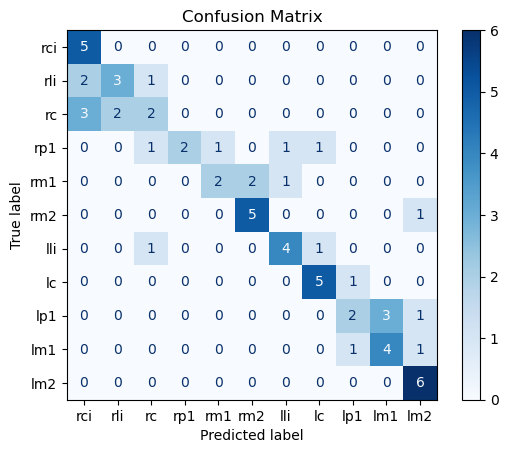

In [48]:
# -------------------------- Classification: SVM

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# 1. Split data, X = features, y = labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Train clf (classifier)
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# 3. Predict 
y_pred = clf.predict(X_test)

# 4. Evaluate 
acc = accuracy_score(y_test, y_pred)
print(f"SVM Test accuracy: {acc:.2f}")

# 5. Confusion matrix 
#cm = confusion_matrix(y_test, y_pred, labels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2','lli', 'lc', 'lp1', 'lp2', 'lm1', 'lm2'])
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2', 'lli', 'lc', 'lp1', 'lp2', 'lm1', 'lm2'])
cm = confusion_matrix(y_test, y_pred, labels=['rci', 'rli', 'rc', 'rp1', 'rm1', 'rm2','lli', 'lc', 'lp1', 'lm1', 'lm2'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rci', 'rli', 'rc', 'rp1', 'rm1', 'rm2', 'lli', 'lc', 'lp1', 'lm1', 'lm2'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



Radom Forest Test Accuracy: 0.58


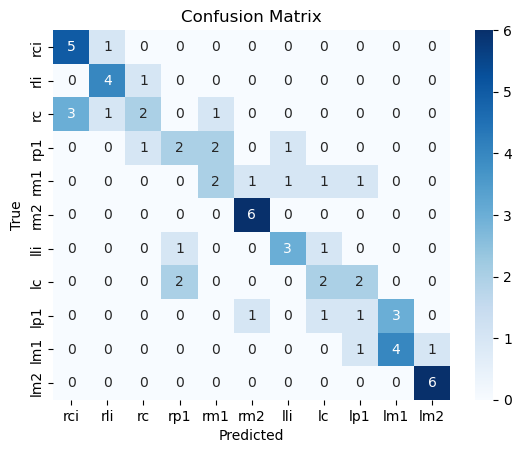

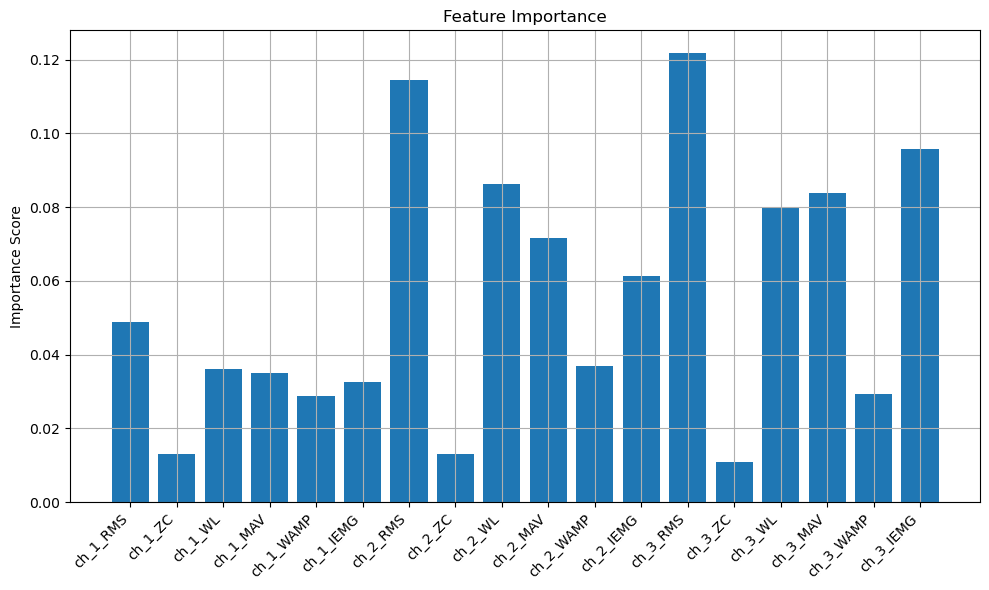

In [46]:
# -------------------------- Classification: Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Train 
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 3. Predict
y_pred = clf.predict(X_test)

# 4. Evaluate
acc = accuracy_score(y_test, y_pred)
#cm = confusion_matrix(y_test, y_pred, labels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2', 'lli', 'lc', 'lp1', 'lp2', 'lm1', 'lm2'])
cm = confusion_matrix(y_test, y_pred, labels=['rci', 'rli', 'rc', 'rp1', 'rm1', 'rm2', 'lli', 'lc', 'lp1', 'lm1', 'lm2'])

print(f"Radom Forest Test Accuracy: {acc:.2f}")

# 5. Plot confusion matrix
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2', 'lli', 'lc', 'lp1', 'lp2', 'lm1', 'lm2'], yticklabels=['rci', 'rli', 'rc', 'rp1', 'rp2', 'rm1', 'rm2', 'lli', 'lc', 'lp1', 'lp2', 'lm1', 'lm2'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rci', 'rli', 'rc', 'rp1', 'rm1', 'rm2', 'lli', 'lc', 'lp1', 'lm1', 'lm2'], yticklabels=['rci', 'rli', 'rc', 'rp1', 'rm1', 'rm2', 'lli', 'lc', 'lp1', 'lm1', 'lm2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Plot feature importance
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()